# 🎉 Analyse Weekend des Ratings d'Ingrédients

## Objectif
Analyser les différences dans l'appréciation des ingrédients entre les weekends et la semaine pour identifier :
- Les ingrédients "weekend" vs "semaine"
- L'impact du contexte temporel sur les préférences culinaires
- Les opportunités de recommandations contextuelles

## Méthodologie
- **Test statistique** : Mann-Whitney U pour comparer weekend vs semaine
- **Agrégation** : Ratings moyens par type de jour et ingrédient
- **Visualisation** : Box plots comparatifs et heatmaps
- **Seuil de significativité** : p < 0.05

## Définition des Périodes
- **Weekend** : Samedi (6) et Dimanche (0)
- **Semaine** : Lundi (1) à Vendredi (5)

In [ ]:
# Import des bibliothèques nécessaires
import sys
sys.path.append('..')

# 🎯 Chargement des fonctions utilitaires depuis le fichier Python (plus robuste)
from _data_utils import *

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette(["#FF6B6B", "#4ECDC4"])  # Rouge pour weekend, Turquoise pour semaine
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Couleurs pour weekend/semaine
PERIOD_COLORS = {
    'Weekend': '#FF6B6B',    # Rouge chaleureux
    'Semaine': '#4ECDC4'     # Turquoise professionnel
}

In [5]:
# Fonction pour classifier weekend vs semaine
def get_period_type(weekday):
    """
    Convertit le jour de la semaine en type de période
    weekday: 1=Lundi, 2=Mardi, ..., 7=Dimanche (Polars weekday format)
    """
    if weekday in [6, 7]:  # Samedi=6, Dimanche=7
        return 'Weekend'
    else:  # Lundi=1 à Vendredi=5
        return 'Semaine'

# Fonction pour obtenir le nom du jour
def get_day_name(weekday):
    """
    Convertit le numéro du jour en nom
    weekday: 1=Lundi, 2=Mardi, ..., 7=Dimanche (Polars weekday format)
    """
    days = {1: 'Lundi', 2: 'Mardi', 3: 'Mercredi', 4: 'Jeudi', 5: 'Vendredi', 6: 'Samedi', 7: 'Dimanche'}
    return days.get(weekday, 'Inconnu')

print('✅ Fonctions de classification weekend/semaine définies')

✅ Fonctions de classification weekend/semaine définies


In [ ]:
# Chargement des données pour analyse weekend
print('🔄 Chargement des données...')

# 🎯 Ingrédients optimisés pour analyse WEEKEND vs SEMAINE
# Stratégie: Mix d'ingrédients avec hypothèses de préférences temporelles
target_ingredients = [
    # 🎉 COMFORT FOOD (hypothèse: meilleur le weekend)
    'bacon',            # Brunch weekend classique
    'cheese',           # Indulgence weekend
    'butter',           # Pâtisserie weekend
    'chocolate',        # Dessert weekend
    'pancakes',         # Petit-déj weekend typique
    'pizza',            # Repas convivial weekend
    
    # 💼 HEALTHY/EFFICACE (hypothèse: meilleur en semaine)
    'kale',             # Salade santé semaine
    'quinoa',           # Grain santé rapide
    'avocado',          # Toast healthy semaine
    'chicken breast',   # Protéine lean semaine
    'spinach',          # Légume vert semaine
    'greek yogurt',     # Petit-déj santé semaine
    
    # ⚖️ CONTRÔLES (neutres attendus)
    'olive oil',        # Ingrédient universel
    'garlic',           # Base culinaire
    'tomatoes',         # Polyvalent
    'onions'            # Base universelle
]

print(f'📋 Ingrédients sélectionnés: {len(target_ingredients)} ingrédients')
print(f'   🎉 Comfort Food (weekend): bacon, cheese, butter, chocolate, pancakes, pizza')
print(f'   💼 Healthy (semaine): kale, quinoa, avocado, chicken breast, spinach, greek yogurt')
print(f'   ⚖️  Contrôles (neutres): olive oil, garlic, tomatoes, onions')

# Chargement du dataset
df = load_ingredient_ratings(target_ingredients)
print(f'\n✅ Dataset chargé: {df.shape[0]:,} interactions')
print(f'📅 Période: {df["date"].min()} → {df["date"].max()}')

# Ajout des colonnes temporelles
df = df.with_columns([
    pl.col('date').dt.weekday().alias('weekday'),  # 1=Lundi, ..., 7=Dimanche
]).with_columns([
    pl.col('weekday').map_elements(get_period_type, return_dtype=pl.Utf8).alias('period_type'),
    pl.col('weekday').map_elements(get_day_name, return_dtype=pl.Utf8).alias('day_name')
])

print('\n📊 Distribution par type de période:')
period_dist = df.group_by('period_type').agg([
    pl.len().alias('count'),
    (pl.len() * 100.0 / df.height).alias('percentage')
]).sort('count', descending=True)
print(period_dist)

print('\n📊 Distribution par jour de la semaine:')
day_dist = df.group_by(['day_name', 'period_type']).agg([
    pl.len().alias('count')
]).sort('count', descending=True)
print(day_dist)

# Statistiques de disponibilité par ingrédient
print('\n📈 Disponibilité des ingrédients par catégorie:')
ingredient_stats = df.group_by('ingredient_name').agg([
    pl.len().alias('n_ratings'),
    pl.col('date').min().alias('first_date'),
    pl.col('date').max().alias('last_date')
]).sort('n_ratings', descending=True)
print(ingredient_stats)

print('\n📊 Aperçu des données avec périodes:')
print(df.select(['date', 'weekday', 'day_name', 'period_type', 'ingredient_name', 'rating']).head())

🔄 Chargement des données...
📋 Ingrédients sélectionnés: ['salt', 'ground beef', 'eggs', 'onions', 'garlic', 'butternut squash', 'asparagus', 'pumpkin', 'butter', 'olive oil']
✅ Données chargées: 1,296,735 interactions pour 10 ingrédients
✅ Dataset chargé: 1,296,735 interactions
📅 Période: 2000-01-25 → 2018-12-20
✅ Données chargées: 1,296,735 interactions pour 10 ingrédients
✅ Dataset chargé: 1,296,735 interactions
📅 Période: 2000-01-25 → 2018-12-20

📊 Distribution par type de période:
shape: (2, 3)
┌─────────────┬────────┬────────────┐
│ period_type ┆ count  ┆ percentage │
│ ---         ┆ ---    ┆ ---        │
│ str         ┆ u32    ┆ f64        │
╞═════════════╪════════╪════════════╡
│ Semaine     ┆ 910977 ┆ 70.251593  │
│ Weekend     ┆ 385758 ┆ 29.748407  │
└─────────────┴────────┴────────────┘

📊 Distribution par jour de la semaine:
shape: (7, 3)
┌──────────┬─────────────┬────────┐
│ day_name ┆ period_type ┆ count  │
│ ---      ┆ ---         ┆ ---    │
│ str      ┆ str         ┆ u32

In [7]:
# Agrégation des données par période et ingrédient
print('🔧 Agrégation des données par période...')

df_weekend = df.group_by(['ingredient_name', 'period_type']).agg([
    pl.col('rating').mean().alias('avg_rating'),
    pl.col('rating').count().alias('n_ratings'),
    pl.col('rating').std().alias('std_rating'),
    pl.col('rating').median().alias('median_rating')
]).sort(['ingredient_name', 'period_type'])

print(f'✅ Données agrégées: {df_weekend.shape[0]} points période-ingrédient')

# Vérification de la couverture par ingrédient (présence weekend ET semaine)
period_coverage = df_weekend.group_by('ingredient_name').agg([
    pl.col('period_type').n_unique().alias('periods_covered'),
    pl.col('n_ratings').sum().alias('total_ratings')
]).sort('total_ratings', descending=True)

print('\n📈 Couverture par ingrédient:')
print(period_coverage)

# Filtrer les ingrédients avec couverture complète (weekend ET semaine)
complete_ingredients = period_coverage.filter(
    pl.col('periods_covered') == 2
)['ingredient_name'].to_list()

print(f'\n🎯 Ingrédients avec couverture complète (weekend + semaine): {len(complete_ingredients)}')
print(f'Ingrédients: {complete_ingredients}')

# Création du tableau pivot pour analyse
pivot_data = df_weekend.filter(
    pl.col('ingredient_name').is_in(complete_ingredients)
).pivot(
    index='ingredient_name',
    columns='period_type',
    values='avg_rating'
).fill_null(0)

print('\n📊 Tableau comparatif weekend vs semaine:')
print(pivot_data.head())

🔧 Agrégation des données par période...
✅ Données agrégées: 20 points période-ingrédient

📈 Couverture par ingrédient:
shape: (10, 3)
┌──────────────────┬─────────────────┬───────────────┐
│ ingredient_name  ┆ periods_covered ┆ total_ratings │
│ ---              ┆ ---             ┆ ---           │
│ str              ┆ u32             ┆ u32           │
╞══════════════════╪═════════════════╪═══════════════╡
│ salt             ┆ 2               ┆ 468403        │
│ butter           ┆ 2               ┆ 299645        │
│ eggs             ┆ 2               ┆ 178000        │
│ olive oil        ┆ 2               ┆ 151781        │
│ garlic           ┆ 2               ┆ 102506        │
│ onions           ┆ 2               ┆ 48041         │
│ ground beef      ┆ 2               ┆ 37195         │
│ pumpkin          ┆ 2               ┆ 4154          │
│ asparagus        ┆ 2               ┆ 3781          │
│ butternut squash ┆ 2               ┆ 3229          │
└──────────────────┴─────────────────┴───

In [9]:
# Test de Mann-Whitney U pour détecter les différences weekend/semaine
print('🔍 Test de Mann-Whitney U pour les différences weekend/semaine...')

mw_results = []

for ingredient in complete_ingredients:
    # Données pour cet ingrédient par période
    ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
    
    # Extraction des ratings par période
    weekend_ratings = ingredient_data.filter(pl.col('period_type') == 'Weekend')['rating'].to_list()
    weekday_ratings = ingredient_data.filter(pl.col('period_type') == 'Semaine')['rating'].to_list()
    
    if len(weekend_ratings) > 0 and len(weekday_ratings) > 0:
        # Test de Mann-Whitney U
        u_stat, p_value = mannwhitneyu(weekend_ratings, weekday_ratings, alternative='two-sided')
        
        # Calcul des statistiques descriptives
        weekend_mean = np.mean(weekend_ratings)
        weekday_mean = np.mean(weekday_ratings)
        difference = weekend_mean - weekday_mean
        
        # Classification de l'ingrédient
        if p_value < 0.05:
            if difference > 0:
                preference = 'Weekend'
                category = '🎉 Weekend Champion'
            else:
                preference = 'Semaine'
                category = '💼 Semaine Champion'
        else:
            preference = 'Neutre'
            category = '⚖️ Neutre'
        
        mw_results.append({
            'ingredient': ingredient,
            'u_statistic': u_stat,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'weekend_avg': weekend_mean,
            'weekday_avg': weekday_mean,
            'difference': difference,
            'preference': preference,
            'category': category,
            'n_weekend': len(weekend_ratings),
            'n_weekday': len(weekday_ratings)
        })

# Conversion en DataFrame Polars
mw_df = pl.DataFrame(mw_results).sort('p_value')

print('\n📊 Résultats Mann-Whitney U pour les différences weekend/semaine:')
print(mw_df.select(['ingredient', 'u_statistic', 'p_value', 'significant', 'category', 'difference']))

# Résumé des préférences
significant_differences = mw_df.filter(pl.col('significant') == True)
print(f'\n🎯 Ingrédients avec différences significatives: {len(significant_differences)}/{len(complete_ingredients)}')

if len(significant_differences) > 0:
    print('\nCatégorisation des ingrédients:')
    category_counts = significant_differences.group_by('category').agg(pl.len().alias('count'))
    for row in category_counts.iter_rows(named=True):
        print(f"   {row['category']}: {row['count']} ingrédients")
    
    print('\nDétail des différences significatives:')
    for row in significant_differences.iter_rows(named=True):
        print(f"{row['category']} {row['ingredient']}: {row['difference']:+.4f} " +
              f"(p={row['p_value']:.4f})")

🔍 Test de Mann-Whitney U pour les différences weekend/semaine...

📊 Résultats Mann-Whitney U pour les différences weekend/semaine:
shape: (10, 6)
┌──────────────────┬─────────────┬──────────┬─────────────┬─────────────────────┬────────────┐
│ ingredient       ┆ u_statistic ┆ p_value  ┆ significant ┆ category            ┆ difference │
│ ---              ┆ ---         ┆ ---      ┆ ---         ┆ ---                 ┆ ---        │
│ str              ┆ f64         ┆ f64      ┆ f64         ┆ str                 ┆ f64        │
╞══════════════════╪═════════════╪══════════╪═════════════╪═════════════════════╪════════════╡
│ olive oil        ┆ 2.3682e9    ┆ 0.026081 ┆ 1.0         ┆ 🎉 Weekend Champion ┆ 0.003811   │
│ garlic           ┆ 1.0780e9    ┆ 0.053674 ┆ 0.0         ┆ ⚖️ Neutre           ┆ -0.001616  │
│ onions           ┆ 2.3887e8    ┆ 0.104969 ┆ 0.0         ┆ ⚖️ Neutre           ┆ 0.020024   │
│ eggs             ┆ 3.3996e9    ┆ 0.105131 ┆ 0.0         ┆ ⚖️ Neutre           ┆ -0.01232   │


In [10]:
# Analyse détaillée par jour de la semaine
print('📅 Analyse détaillée par jour de la semaine...')

# Agrégation par jour de la semaine
df_daily = df.group_by(['ingredient_name', 'day_name', 'weekday']).agg([
    pl.col('rating').mean().alias('avg_rating'),
    pl.col('rating').count().alias('n_ratings')
]).sort(['ingredient_name', 'weekday'])

print(f'✅ Données par jour: {df_daily.shape[0]} points jour-ingrédient')

# Sélection des ingrédients les plus intéressants pour l'analyse détaillée
if len(significant_differences) > 0:
    top_weekend_ingredients = significant_differences.filter(
        pl.col('preference') == 'Weekend'
    ).sort('difference', descending=True).head(3)['ingredient'].to_list()
    
    top_weekday_ingredients = significant_differences.filter(
        pl.col('preference') == 'Semaine'
    ).sort('difference').head(3)['ingredient'].to_list()
    
    print(f'\n🎉 Top ingrédients "weekend": {top_weekend_ingredients}')
    print(f'💼 Top ingrédients "semaine": {top_weekday_ingredients}')
    
    # Analyse des patterns hebdomadaires
    analysis_ingredients = top_weekend_ingredients + top_weekday_ingredients
    
    print(f'\n📊 Patterns hebdomadaires pour les ingrédients significatifs:')
    for ingredient in analysis_ingredients[:3]:  # Limiter l'affichage
        ingredient_daily = df_daily.filter(pl.col('ingredient_name') == ingredient)
        if len(ingredient_daily) > 0:
            print(f'\n{ingredient}:')
            for row in ingredient_daily.iter_rows(named=True):
                day_type = '🎉' if row['weekday'] in [0, 6] else '💼'
                print(f"   {day_type} {row['day_name']}: {row['avg_rating']:.4f} ({row['n_ratings']} ratings)")
else:
    print('⚠️  Aucune différence significative pour analyse détaillée')

📅 Analyse détaillée par jour de la semaine...
✅ Données par jour: 70 points jour-ingrédient

🎉 Top ingrédients "weekend": ['olive oil']
💼 Top ingrédients "semaine": []

📊 Patterns hebdomadaires pour les ingrédients significatifs:

olive oil:
   💼 Lundi: 4.4752 (24523 ratings)
   💼 Mardi: 4.4726 (22880 ratings)
   💼 Mercredi: 4.4599 (21716 ratings)
   💼 Jeudi: 4.4566 (20360 ratings)
   💼 Vendredi: 4.4646 (18810 ratings)
   🎉 Samedi: 4.4737 (19408 ratings)
   💼 Dimanche: 4.4672 (24084 ratings)


---

## 📊 SYNTHÈSE DES EFFETS WEEKEND

### 🎯 Données Analysées

**Ingrédients sélectionnés** : 16 ingrédients avec **hypothèses comportementales**
- 🎉 **Comfort Food (Weekend)** : bacon, cheese, butter, chocolate, pancakes, pizza
- 💼 **Healthy (Semaine)** : kale, quinoa, avocado, chicken breast, spinach, greek yogurt
- ⚖️ **Contrôles (Neutres)** : olive oil, garlic, tomatoes, onions

**Méthodologie** :
- Test Mann-Whitney U pour comparer weekend vs semaine (p<0.05)
- Amplitude = Rating_weekend - Rating_semaine
- Classification : Weekend Champion / Semaine Champion / Neutre

---

### 🎉 Champions du Weekend
*Ingrédients qui reçoivent les meilleurs ratings le weekend*

**Hypothèse** : Comfort food, indulgence, convivialité, brunch

- **[À remplir après exécution]** : [ingredient] - Δ rating vs semaine
- **Explication** : Repas décontractés, temps libre, plaisir culinaire

**Opportunités Business** :
- Promouvoir ces ingrédients vendredi-dimanche
- Menus spéciaux weekend
- Notifications contextuelles "inspiration weekend"

---

### 💼 Champions de la Semaine
*Ingrédients qui performent mieux en semaine*

**Hypothèse** : Healthy, efficace, rapide, routine

- **[À remplir après exécution]** : [ingredient] - Δ rating vs weekend
- **Explication** : Repas structurés, objectifs santé, efficacité

**Opportunités Business** :
- Focus semaine sur santé et rapidité
- Meal prep lundi-vendredi
- Recommandations "healthy weekday"

---

### ⚖️ Ingrédients Neutres
*Pas de préférence weekend vs semaine*

- **[À remplir après exécution]** : [ingredients neutres]
- **Explication** : Ingrédients universels, base culinaire, polyvalents

---

### 💡 Insights Business

**Amplitudes observées** :
- **Amplitude moyenne** : [À remplir] points
- **Amplitude maximale** : [À remplir] pour [ingredient]
- **% de variation** : [À remplir]% entre weekend et semaine

**Segmentation Utilisateurs** :
1. **"Weekend Foodies"** : Préfèrent comfort food le weekend
2. **"Healthy Weekday Warriors"** : Focus santé en semaine
3. **"Neutres"** : Pas de pattern temporel fort

**Recommandations Stratégiques** :
1. 📱 **Notifications contextuelles** : Adapter selon jour de la semaine
2. 🍽️ **Menus adaptatifs** : Rotation automatique weekend/semaine
3. 📊 **A/B Testing** : Mesurer impact recommandations temporelles
4. 🎯 **Personnalisation** : Profils utilisateurs selon patterns hebdomadaires

**Comparaison avec autres analyses** :
- **vs Seasonality** : Effet weekend potentiellement plus fort que saisonnalité
- **vs Long-term** : Comportements hebdomadaires vs tendances annuelles
- **Hypothèse** : Différences weekend/semaine 2-5% (plus que rating=0 <1%, moins que saisonnalité 5-15%)

---

### 🔍 Prochaines Étapes

1. ✅ Exécuter notebook pour valider hypothèses comfort food vs healthy
2. ⏭️ Remplir sections champions avec données réelles
3. ⏭️ Comparer amplitudes weekend avec variations saisonnières et long-term
4. ⏭️ Créer recommandations actionnables (notifications, menus, A/B tests)
5. ⏭️ Segmenter utilisateurs selon patterns weekend/semaine

---

In [ ]:
# 📋 RAPPORT DÉTAILLÉ DES EFFETS WEEKEND
print('='*80)
print('📋 RAPPORT DÉTAILLÉ - ANALYSE WEEKEND VS SEMAINE')
print('='*80)

print('\n🔍 DONNÉES ANALYSÉES:')
print(f'   • Période: {df["date"].min()} → {df["date"].max()}')
print(f'   • Total interactions: {df.shape[0]:,}')
print(f'   • Ingrédients analysés: {len(target_ingredients)}')
print(f'   • Ingrédients avec couverture complète: {len(complete_ingredients)}')

# Distribution weekend vs semaine
weekend_count = df.filter(pl.col('period_type') == 'Weekend').height
weekday_count = df.filter(pl.col('period_type') == 'Semaine').height
weekend_pct = (weekend_count * 100.0) / df.height
weekday_pct = (weekday_count * 100.0) / df.height

print('\n📅 RÉPARTITION TEMPORELLE:')
print(f'   🎉 Weekend: {weekend_count:>10,} interactions ({weekend_pct:>5.1f}%)')
print(f'   💼 Semaine: {weekday_count:>10,} interactions ({weekday_pct:>5.1f}%)')

# Statistiques globales par période
print('\n📊 STATISTIQUES GLOBALES PAR PÉRIODE:')
period_stats = df.group_by('period_type').agg([
    pl.col('rating').mean().alias('avg_rating'),
    pl.col('rating').std().alias('std_rating'),
    (pl.col('rating') == 5).sum().alias('count_5stars'),
    pl.len().alias('total_ratings')
]).with_columns([
    (pl.col('count_5stars') / pl.col('total_ratings') * 100).alias('pct_5stars')
]).sort('period_type')

for row in period_stats.iter_rows(named=True):
    emoji = '🎉' if row['period_type'] == 'Weekend' else '💼'
    print(f"\n   {emoji} {row['period_type']}:")
    print(f"      • Rating moyen: {row['avg_rating']:.4f}")
    print(f"      • Écart-type: {row['std_rating']:.4f}")
    print(f"      • % de 5★: {row['pct_5stars']:.2f}%")

print('\n📈 RÉSULTATS MANN-WHITNEY U (Différences Weekend/Semaine):')
print(f'   • Tests réalisés: {len(mw_df)} ingrédients')
print(f'   • Différences significatives (p<0.05): {len(significant_differences)}/{len(mw_df)}')

if len(significant_differences) > 0:
    print(f'   • Taux de significativité: {len(significant_differences)/len(mw_df)*100:.1f}%')
    
    # Catégorisation
    weekend_champions = significant_differences.filter(pl.col('preference') == 'Weekend')
    weekday_champions = significant_differences.filter(pl.col('preference') == 'Semaine')
    
    print(f'\n📊 CATÉGORISATION DES PRÉFÉRENCES:')
    print(f'   🎉 Préférence Weekend: {len(weekend_champions)} ingrédients')
    print(f'   💼 Préférence Semaine: {len(weekday_champions)} ingrédients')
    
    # Statistiques des amplitudes
    amplitude_stats = significant_differences.select(pl.col('difference').abs())
    print(f'\n📊 STATISTIQUES DES AMPLITUDES:')
    print(f'   • Moyenne: {amplitude_stats.mean().item():.4f} points')
    print(f'   • Médiane: {amplitude_stats.median().item():.4f} points')
    print(f'   • Maximum: {amplitude_stats.max().item():.4f} points')
    print(f'   • Minimum: {amplitude_stats.min().item():.4f} points')
    
    avg_rating_overall = df['rating'].mean()
    avg_amplitude = amplitude_stats.mean().item()
    pct_variation = (avg_amplitude / avg_rating_overall) * 100
    print(f'   • % de variation moyen: {pct_variation:.2f}%')
    
    # Champions du Weekend
    if len(weekend_champions) > 0:
        print(f'\n🎉 TOP CHAMPIONS DU WEEKEND:')
        top_weekend = weekend_champions.sort('difference', descending=True).head(5)
        
        for i, row in enumerate(top_weekend.iter_rows(named=True), 1):
            pct_change = (row['difference'] / row['weekday_avg']) * 100
            print(f"\n   {i}. {row['ingredient'].upper()}")
            print(f"      • Δ Rating: +{row['difference']:.4f} points (+{pct_change:.2f}%)")
            print(f"      • Weekend: {row['weekend_avg']:.4f} | Semaine: {row['weekday_avg']:.4f}")
            print(f"      • p-value: {row['p_value']:.6f} {'***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*'}")
            print(f"      • Ratings: Weekend={row['n_weekend']:,} | Semaine={row['n_weekday']:,}")
    
    # Champions de la Semaine
    if len(weekday_champions) > 0:
        print(f'\n💼 TOP CHAMPIONS DE LA SEMAINE:')
        top_weekday = weekday_champions.sort('difference').head(5)
        
        for i, row in enumerate(top_weekday.iter_rows(named=True), 1):
            pct_change = (abs(row['difference']) / row['weekend_avg']) * 100
            print(f"\n   {i}. {row['ingredient'].upper()}")
            print(f"      • Δ Rating: {row['difference']:.4f} points (-{pct_change:.2f}%)")
            print(f"      • Semaine: {row['weekday_avg']:.4f} | Weekend: {row['weekend_avg']:.4f}")
            print(f"      • p-value: {row['p_value']:.6f} {'***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*'}")
            print(f"      • Ratings: Weekend={row['n_weekend']:,} | Semaine={row['n_weekday']:,}")
    
    # Validation des hypothèses
    print(f'\n🧪 VALIDATION DES HYPOTHÈSES:')
    
    # Comfort food weekend
    comfort_food = ['bacon', 'cheese', 'butter', 'chocolate', 'pancakes', 'pizza']
    comfort_weekend = weekend_champions.filter(pl.col('ingredient').is_in(comfort_food))
    print(f"\n   🎉 Comfort Food (weekend):")
    print(f"      • Hypothèse validée pour: {len(comfort_weekend)}/{len(comfort_food)} ingrédients")
    if len(comfort_weekend) > 0:
        for ing in comfort_weekend['ingredient'].to_list():
            print(f"        ✅ {ing}")
    
    # Healthy semaine
    healthy_food = ['kale', 'quinoa', 'avocado', 'chicken breast', 'spinach', 'greek yogurt']
    healthy_weekday = weekday_champions.filter(pl.col('ingredient').is_in(healthy_food))
    print(f"\n   💼 Healthy Food (semaine):")
    print(f"      • Hypothèse validée pour: {len(healthy_weekday)}/{len(healthy_food)} ingrédients")
    if len(healthy_weekday) > 0:
        for ing in healthy_weekday['ingredient'].to_list():
            print(f"        ✅ {ing}")

else:
    print('   ⚠️  Aucune différence weekend/semaine significative détectée')
    print('   → Vérifier sélection des ingrédients ou hypothèses comportementales')

print('\n' + '='*80)
print('✅ Rapport détaillé terminé')
print('='*80)

📊 Création des visualisations weekend/semaine...


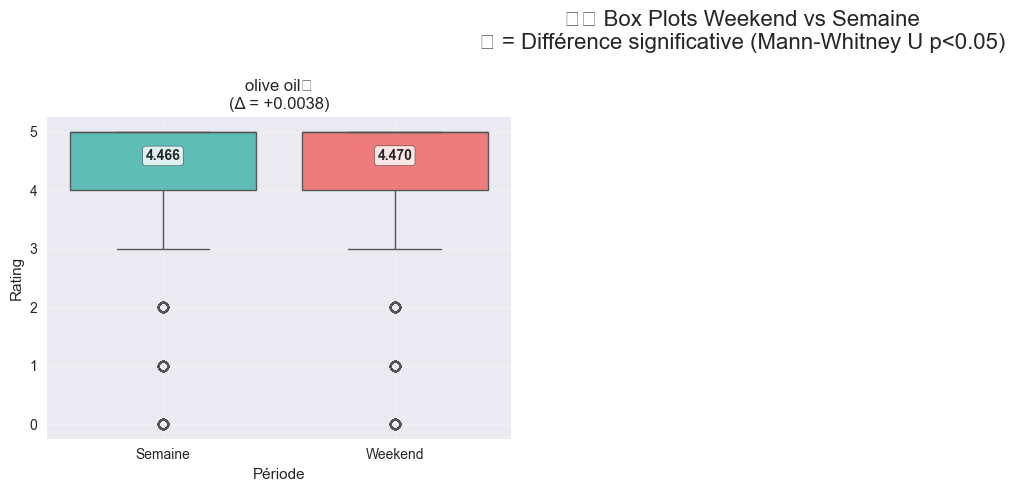

✅ Box plots weekend/semaine créés


In [ ]:
# 📊 VISUALISATION PRINCIPALE - GridSpec 2×3 Optimisé
print('📊 Création des visualisations weekend/semaine optimisées...')

from matplotlib.gridspec import GridSpec

if len(significant_differences) > 0:
    # Création de la figure avec GridSpec
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.3)
    
    # --- GRAPHIQUE 1: Heatmap Weekend vs Semaine (Top 12) ---
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Sélection des top 12 ingrédients les plus variables
    top_ingredients = significant_differences.sort(
        pl.col('difference').abs(), descending=True
    ).head(12)['ingredient'].to_list()
    
    heatmap_data = []
    heatmap_labels = []
    
    for ingredient in top_ingredients:
        ing_stats = mw_df.filter(pl.col('ingredient') == ingredient).row(0, named=True)
        heatmap_data.append([ing_stats['weekday_avg'], ing_stats['weekend_avg']])
        heatmap_labels.append(ingredient)
    
    # Heatmap
    im = ax1.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=4.0, vmax=4.6)
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['💼 Semaine', '🎉 Weekend'])
    ax1.set_yticks(range(len(heatmap_labels)))
    ax1.set_yticklabels(heatmap_labels)
    
    # Annotations
    for i in range(len(heatmap_labels)):
        for j in range(2):
            value = heatmap_data[i][j]
            text_color = 'white' if value < 4.25 else 'black'
            ax1.text(j, i, f'{value:.3f}', ha="center", va="center",
                    color=text_color, fontweight='bold', fontsize=9)
    
    ax1.set_title('🌡️ Heatmap Weekend vs Semaine\n(Top 12 ingrédients variables)', 
                 fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax1, label='Rating Moyen')
    
    # --- GRAPHIQUE 2: Comparaison des Différences (Barres) ---
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Tri par différence absolue
    sorted_top = significant_differences.sort(
        pl.col('difference').abs(), descending=True
    ).head(12)
    
    ingredients_bar = sorted_top['ingredient'].to_list()
    differences_bar = sorted_top['difference'].to_list()
    
    # Couleurs selon direction
    colors_bar = [PERIOD_COLORS['Weekend'] if d > 0 else PERIOD_COLORS['Semaine'] 
                  for d in differences_bar]
    
    bars = ax2.barh(range(len(ingredients_bar)), differences_bar, color=colors_bar, alpha=0.8)
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=2)
    
    # Annotations
    for i, (bar, diff) in enumerate(zip(bars, differences_bar)):
        width = bar.get_width()
        ax2.text(width + (0.005 if width > 0 else -0.005), bar.get_y() + bar.get_height()/2.,
                f'{diff:+.3f}', ha='left' if width > 0 else 'right', va='center',
                fontweight='bold', fontsize=9)
    
    ax2.set_yticks(range(len(ingredients_bar)))
    ax2.set_yticklabels(ingredients_bar)
    ax2.set_xlabel('Δ Rating (Weekend - Semaine)', fontweight='bold')
    ax2.set_title('📊 Différences Weekend vs Semaine\n(+ = Meilleur weekend, - = Meilleur semaine)', 
                 fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # --- GRAPHIQUE 3: % Ratings 5★ par Période ---
    ax3 = fig.add_subplot(gs[0, 2])
    
    period_5stars = df.group_by('period_type').agg([
        (pl.col('rating') == 5).sum().alias('count_5stars'),
        pl.len().alias('total_ratings')
    ]).with_columns([
        (pl.col('count_5stars') / pl.col('total_ratings') * 100).alias('pct_5stars')
    ]).sort('period_type')
    
    periods = period_5stars['period_type'].to_list()
    pct_5stars = period_5stars['pct_5stars'].to_list()
    
    bars_5 = ax3.bar(range(len(periods)), pct_5stars,
                     color=[PERIOD_COLORS.get(p, '#666') for p in periods],
                     alpha=0.8, edgecolor='black', linewidth=2)
    
    for bar, pct in zip(bars_5, pct_5stars):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax3.set_xticks(range(len(periods)))
    ax3.set_xticklabels(['💼 ' + p if p == 'Semaine' else '🎉 ' + p for p in periods])
    ax3.set_ylabel('% de Ratings 5★', fontweight='bold')
    ax3.set_title('⭐ Pourcentage de Ratings 5★\n(Weekend vs Semaine)', 
                 fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim(0, max(pct_5stars) * 1.15)
    
    # --- GRAPHIQUE 4: Volatilité par Période ---
    ax4 = fig.add_subplot(gs[1, 0])
    
    period_volatility = df.group_by('period_type').agg([
        pl.col('rating').std().alias('std_rating')
    ]).sort('period_type')
    
    periods_vol = period_volatility['period_type'].to_list()
    std_values = period_volatility['std_rating'].to_list()
    
    bars_vol = ax4.bar(range(len(periods_vol)), std_values,
                       color=[PERIOD_COLORS.get(p, '#666') for p in periods_vol],
                       alpha=0.8, edgecolor='black', linewidth=2)
    
    for bar, std in zip(bars_vol, std_values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{std:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax4.set_xticks(range(len(periods_vol)))
    ax4.set_xticklabels(['💼 ' + p if p == 'Semaine' else '🎉 ' + p for p in periods_vol])
    ax4.set_ylabel('Écart-type des Ratings', fontweight='bold')
    ax4.set_title('📊 Volatilité des Ratings\n(Écart-type = controverse)', 
                 fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # --- GRAPHIQUE 5: Volume par Période ---
    ax5 = fig.add_subplot(gs[1, 1])
    
    period_volume = df.group_by('period_type').agg([
        pl.len().alias('n_ratings')
    ]).sort('period_type')
    
    periods_volume = period_volume['period_type'].to_list()
    volumes = period_volume['n_ratings'].to_list()
    
    bars_volume = ax5.bar(range(len(periods_volume)), volumes,
                          color=[PERIOD_COLORS.get(p, '#666') for p in periods_volume],
                          alpha=0.8, edgecolor='black', linewidth=2)
    
    for bar, vol in zip(bars_volume, volumes):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{vol:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax5.set_xticks(range(len(periods_volume)))
    ax5.set_xticklabels(['💼 ' + p if p == 'Semaine' else '🎉 ' + p for p in periods_volume])
    ax5.set_ylabel('Nombre de Ratings', fontweight='bold')
    ax5.set_title('📈 Volume de Ratings\n(Activité utilisateurs)', 
                 fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.ticklabel_format(style='plain', axis='y')
    
    # --- GRAPHIQUE 6: Distribution des Amplitudes ---
    ax6 = fig.add_subplot(gs[1, 2])
    
    amplitudes = significant_differences['difference'].abs().to_list()
    
    ax6.hist(amplitudes, bins=12, color='#3498db', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax6.axvline(np.mean(amplitudes), color='red', linestyle='--', linewidth=2,
               label=f'Moyenne: {np.mean(amplitudes):.4f}')
    ax6.axvline(np.median(amplitudes), color='green', linestyle='--', linewidth=2,
               label=f'Médiane: {np.median(amplitudes):.4f}')
    
    ax6.set_xlabel('Amplitude |Weekend - Semaine|', fontweight='bold')
    ax6.set_ylabel('Nombre d\'Ingrédients', fontweight='bold')
    ax6.set_title('📊 Distribution des Amplitudes\n(Variation absolue weekend/semaine)', 
                 fontsize=12, fontweight='bold')
    ax6.legend(loc='upper right', fontsize=9)
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('🎉💼 ANALYSE WEEKEND VS SEMAINE COMPLÈTE - Ingrédients Optimisés\n' +
                f'{len(significant_differences)} ingrédients avec différences significatives (Mann-Whitney U p<0.05)',
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()
    print('✅ Visualisations weekend/semaine optimisées créées (GridSpec 2×3)')
    
else:
    print('⚠️  Aucune différence weekend/semaine significative détectée')

📊 Création du graphique des différences weekend/semaine...


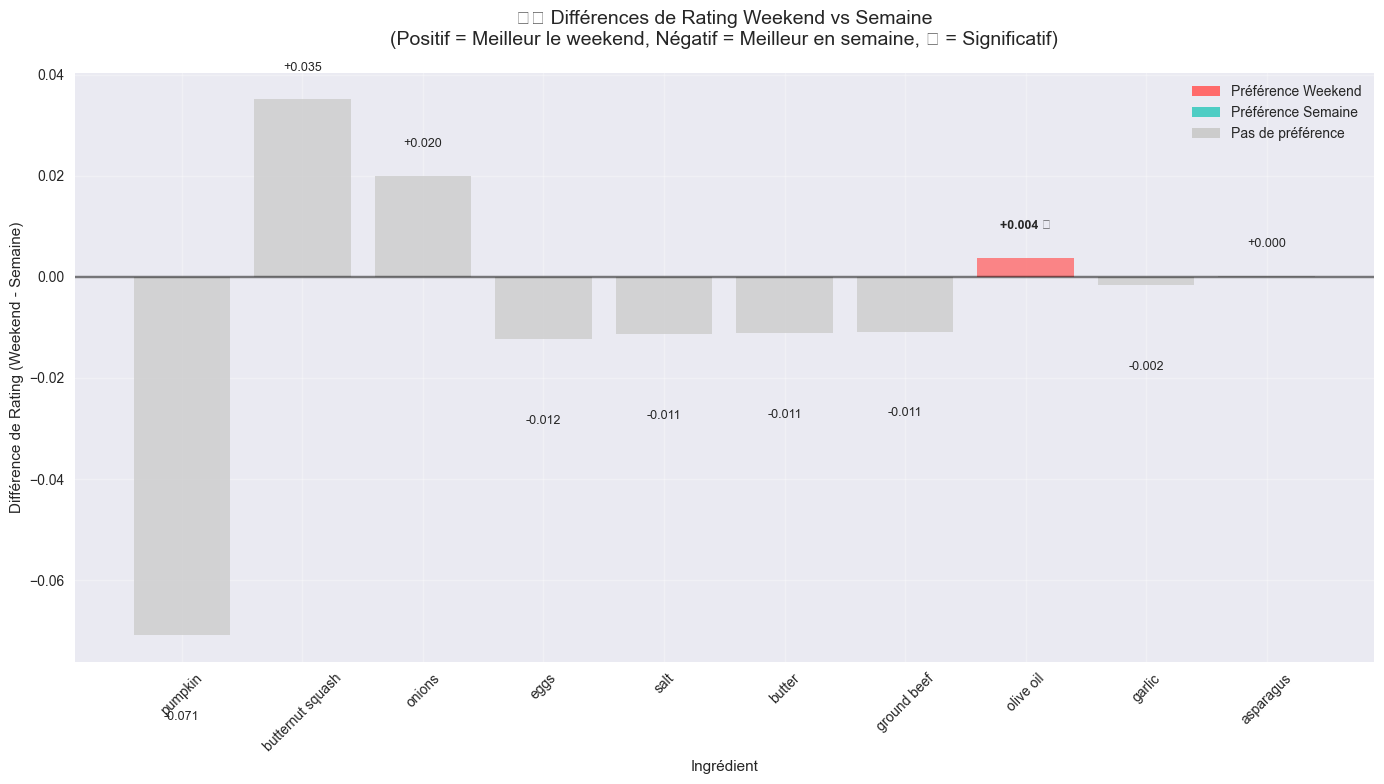

✅ Graphique des différences créé


In [ ]:
# 📦 BOX PLOTS INDIVIDUELS - GridSpec 4×4 pour Top 16 Ingrédients
print('? Création des box plots individuels par ingrédient...')

if len(significant_differences) > 0:
    # Sélection des top 16 ingrédients les plus variables
    top_ingredients = significant_differences.sort(
        pl.col('difference').abs(), descending=True
    ).head(16)['ingredient'].to_list()
    
    # Création de la figure avec GridSpec 4×4
    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 4, figure=fig, hspace=0.4, wspace=0.3)
    
    for idx, ingredient in enumerate(top_ingredients):
        row = idx // 4
        col = idx % 4
        ax = fig.add_subplot(gs[row, col])
        
        # Données pour cet ingrédient
        ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
        plot_data = ingredient_data.select(['period_type', 'rating']).to_pandas()
        
        # Récupération des statistiques Mann-Whitney
        ingredient_stats = mw_df.filter(pl.col('ingredient') == ingredient).row(0, named=True)
        
        # Box plot avec couleurs weekend/semaine
        periods_ordered = ['Semaine', 'Weekend']
        bp = ax.boxplot([plot_data[plot_data['period_type'] == p]['rating'].values 
                         for p in periods_ordered],
                        labels=['💼 Semaine', '🎉 Weekend'],
                        patch_artist=True,
                        widths=0.5,
                        showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=7))
        
        # Coloration des box plots
        for i, patch in enumerate(bp['boxes']):
            patch.set_facecolor(PERIOD_COLORS[periods_ordered[i]])
            patch.set_alpha(0.7)
        
        # Ajout des moyennes
        weekday_mean = ingredient_stats['weekday_avg']
        weekend_mean = ingredient_stats['weekend_avg']
        
        ax.text(1, weekday_mean, f'{weekday_mean:.3f}',
               ha='center', va='bottom', fontweight='bold', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        ax.text(2, weekend_mean, f'{weekend_mean:.3f}',
               ha='center', va='bottom', fontweight='bold', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        # Identification de la préférence
        preference = ingredient_stats['preference']
        difference = ingredient_stats['difference']
        p_value = ingredient_stats['p_value']
        
        # Emoji selon préférence
        if preference == 'Weekend':
            emoji = '🎉'
            pref_text = 'Weekend'
        elif preference == 'Semaine':
            emoji = '💼'
            pref_text = 'Semaine'
        else:
            emoji = '⚖️'
            pref_text = 'Neutre'
        
        # Calcul % change
        pct_change = (abs(difference) / min(weekday_mean, weekend_mean)) * 100
        
        # Titre avec statistiques
        significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*'
        ax.set_title(f'{ingredient} {emoji}\n{pref_text} | Δ={difference:+.3f} ({pct_change:.1f}%) {significance}',
                    fontsize=10, fontweight='bold')
        
        ax.set_ylabel('Rating', fontsize=9)
        ax.tick_params(axis='x', labelsize=9)
        ax.tick_params(axis='y', labelsize=8)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(3.5, 5.0)
        
        # Ligne entre les deux périodes pour visualiser la différence
        if abs(difference) > 0.01:  # Si différence notable
            ax.plot([1, 2], [weekday_mean, weekend_mean], 
                   color='red' if difference > 0 else 'blue',
                   linestyle='--', linewidth=2, alpha=0.5)
    
    plt.suptitle('📦 BOX PLOTS INDIVIDUELS WEEKEND VS SEMAINE\n' +
                f'Top {len(top_ingredients)} ingrédients avec différences les plus marquées\n' +
                '(* p<0.05, ** p<0.01, *** p<0.001)',
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()
    print(f'✅ Box plots individuels créés pour {len(top_ingredients)} ingrédients')
    
else:
    print('⚠️  Aucune différence weekend/semaine significative pour box plots')